Using device: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 340kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.21MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.2MB/s]


Model initialized with 973624 parameters

Training VAE...
Epoch [10/50], Total Loss: 104.7670, Recon Loss: 86.6060, KL Loss: 18.1611
Epoch [20/50], Total Loss: 100.4962, Recon Loss: 81.1817, KL Loss: 19.3145
Epoch [30/50], Total Loss: 98.8015, Recon Loss: 79.1822, KL Loss: 19.6193
Epoch [40/50], Total Loss: 97.8154, Recon Loss: 78.0420, KL Loss: 19.7734
Epoch [50/50], Total Loss: 97.1698, Recon Loss: 77.3143, KL Loss: 19.8555


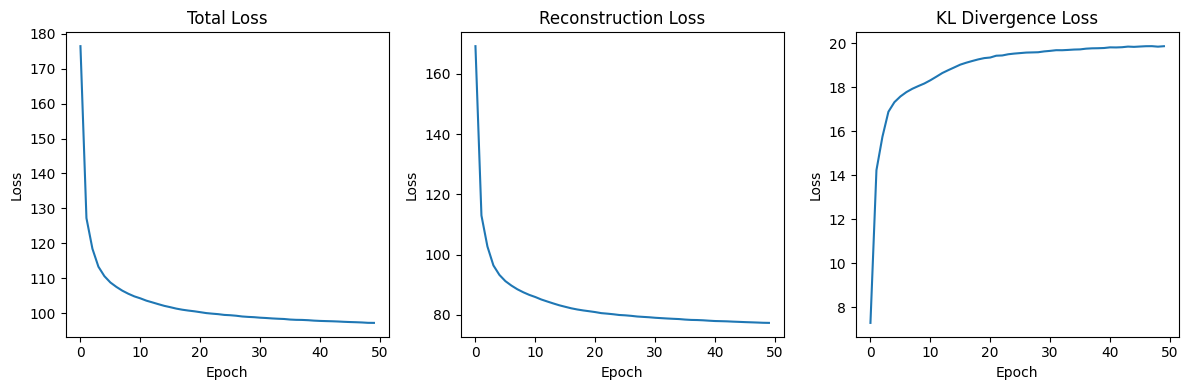


Visualizing results...


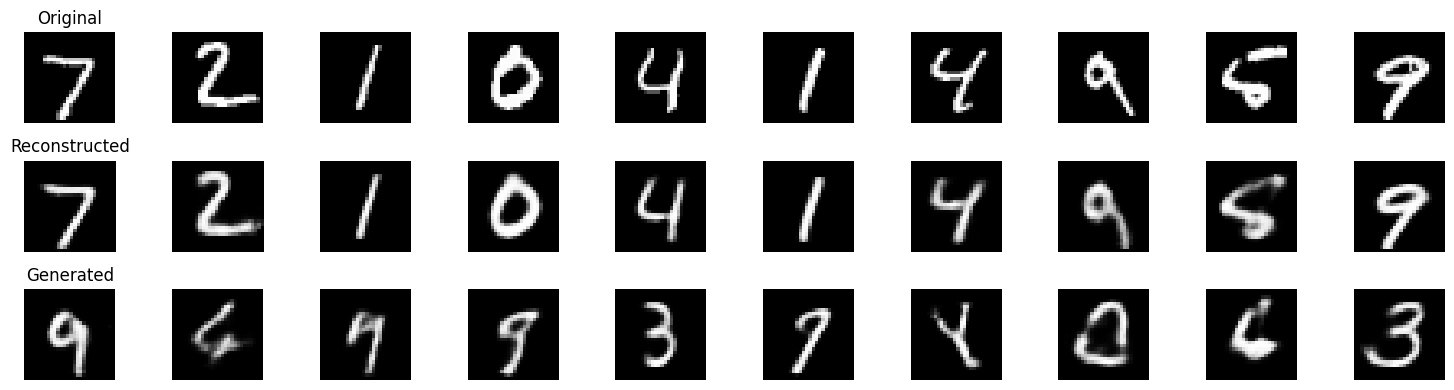


Model saved as 'vae_model.pth'


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class VAE(nn.Module):
    """Variational Autoencoder implementation"""

    def __init__(self, input_dim: int = 784, hidden_dim: int = 400,
                 latent_dim: int = 20):
        """
        Initialize VAE architecture

        Args:
            input_dim: Dimension of input data (784 for MNIST 28x28 images)
            hidden_dim: Dimension of hidden layers
            latent_dim: Dimension of latent space
        """
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

        # Latent space parameters
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)      # Mean
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)  # Log variance

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)

    def encoder(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Encode input to latent space parameters

        Args:
            x: Input tensor

        Returns:
            mu: Mean of latent distribution
            logvar: Log variance of latent distribution
        """
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick for sampling from latent distribution

        Args:
            mu: Mean of latent distribution
            logvar: Log variance of latent distribution

        Returns:
            z: Sampled latent vector
        """
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            # During evaluation, return the mean
            return mu

    def decoder(self, z: torch.Tensor) -> torch.Tensor:
        """
        Decode latent vector to reconstruction

        Args:
            z: Latent vector

        Returns:
            reconstruction: Reconstructed output
        """
        h = F.relu(self.fc3(z))
        h = F.relu(self.fc4(h))
        reconstruction = torch.sigmoid(self.fc5(h))
        return reconstruction

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass through VAE

        Args:
            x: Input tensor

        Returns:
            reconstruction: Reconstructed output
            mu: Mean of latent distribution
            logvar: Log variance of latent distribution
        """
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decoder(z)
        return reconstruction, mu, logvar

    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Generate samples from the learned distribution

        Args:
            num_samples: Number of samples to generate

        Returns:
            samples: Generated samples
        """
        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_dim).to(device)
            samples = self.decoder(z)
        return samples


def vae_loss(reconstruction: torch.Tensor, original: torch.Tensor,
             mu: torch.Tensor, logvar: torch.Tensor, beta: float = 1.0) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Calculate VAE loss (reconstruction loss + KL divergence)

    Args:
        reconstruction: Reconstructed output
        original: Original input
        mu: Mean of latent distribution
        logvar: Log variance of latent distribution
        beta: Weight for KL divergence term (beta-VAE)

    Returns:
        total_loss: Combined loss
        recon_loss: Reconstruction loss
        kl_loss: KL divergence loss
    """
    # Reconstruction loss (Binary Cross Entropy)
    recon_loss = F.binary_cross_entropy(reconstruction, original, reduction='sum')

    # KL divergence loss
    # KL(q(z|x) || p(z)) where p(z) is N(0, I)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss


def train_vae(model: VAE, dataloader: DataLoader, num_epochs: int = 50,
              learning_rate: float = 1e-3, beta: float = 1.0) -> dict:
    """
    Train the VAE model

    Args:
        model: VAE model
        dataloader: Training data loader
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        beta: Weight for KL divergence term

    Returns:
        history: Training history
    """
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    history = {
        'total_loss': [],
        'recon_loss': [],
        'kl_loss': []
    }

    for epoch in range(num_epochs):
        epoch_total_loss = 0
        epoch_recon_loss = 0
        epoch_kl_loss = 0

        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.view(-1, 784).to(device)

            optimizer.zero_grad()

            # Forward pass
            reconstruction, mu, logvar = model(data)

            # Calculate loss
            loss, recon_loss, kl_loss = vae_loss(reconstruction, data, mu, logvar, beta)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Accumulate losses
            epoch_total_loss += loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += kl_loss.item()

        # Average losses
        avg_total_loss = epoch_total_loss / len(dataloader.dataset)
        avg_recon_loss = epoch_recon_loss / len(dataloader.dataset)
        avg_kl_loss = epoch_kl_loss / len(dataloader.dataset)

        history['total_loss'].append(avg_total_loss)
        history['recon_loss'].append(avg_recon_loss)
        history['kl_loss'].append(avg_kl_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Total Loss: {avg_total_loss:.4f}, '
                  f'Recon Loss: {avg_recon_loss:.4f}, '
                  f'KL Loss: {avg_kl_loss:.4f}')

    return history


def visualize_results(model: VAE, dataloader: DataLoader, num_samples: int = 10):
    """
    Visualize original images, reconstructions, and generated samples

    Args:
        model: Trained VAE model
        dataloader: Data loader for test data
        num_samples: Number of samples to visualize
    """
    model.eval()

    # Get a batch of test data
    data_iter = iter(dataloader)
    test_data, _ = next(data_iter)
    test_data = test_data[:num_samples].view(-1, 784).to(device)

    with torch.no_grad():
        # Get reconstructions
        reconstructions, _, _ = model(test_data)

        # Generate new samples
        generated = model.sample(num_samples)

    # Convert to numpy for plotting
    test_data = test_data.cpu().numpy().reshape(-1, 28, 28)
    reconstructions = reconstructions.cpu().numpy().reshape(-1, 28, 28)
    generated = generated.cpu().numpy().reshape(-1, 28, 28)

    # Create figure
    fig, axes = plt.subplots(3, num_samples, figsize=(15, 4))

    for i in range(num_samples):
        # Original images
        axes[0, i].imshow(test_data[i], cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=12)

        # Reconstructions
        axes[1, i].imshow(reconstructions[i], cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed', fontsize=12)

        # Generated samples
        axes[2, i].imshow(generated[i], cmap='gray')
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_title('Generated', fontsize=12)

    plt.tight_layout()
    plt.show()


def plot_latent_space(model: VAE, dataloader: DataLoader, num_batches: int = 50):
    """
    Visualize the latent space (for 2D latent space)

    Args:
        model: Trained VAE model
        dataloader: Data loader
        num_batches: Number of batches to use for visualization
    """
    if model.latent_dim != 2:
        print("Latent space visualization only works for 2D latent space")
        return

    model.eval()

    latents = []
    labels = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            if batch_idx >= num_batches:
                break

            data = data.view(-1, 784).to(device)
            mu, _ = model.encoder(data)

            latents.append(mu.cpu().numpy())
            labels.append(target.numpy())

    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', s=2, alpha=0.7)
    plt.colorbar(scatter)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Visualization')
    plt.show()


def main():
    """Main function to train and evaluate VAE"""

    # Hyperparameters
    BATCH_SIZE = 128
    LEARNING_RATE = 1e-3
    NUM_EPOCHS = 50
    LATENT_DIM = 20  # Change to 2 for latent space visualization
    HIDDEN_DIM = 400
    BETA = 1.0  # Beta parameter for beta-VAE (1.0 for standard VAE)

    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model
    model = VAE(input_dim=784, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM).to(device)
    print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

    # Train model
    print("\nTraining VAE...")
    history = train_vae(model, train_loader, num_epochs=NUM_EPOCHS,
                       learning_rate=LEARNING_RATE, beta=BETA)

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(history['total_loss'])
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 3, 2)
    plt.plot(history['recon_loss'])
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 3, 3)
    plt.plot(history['kl_loss'])
    plt.title('KL Divergence Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

    # Visualize results
    print("\nVisualizing results...")
    visualize_results(model, test_loader, num_samples=10)

    # Visualize latent space (only works if LATENT_DIM = 2)
    if LATENT_DIM == 2:
        print("\nVisualizing latent space...")
        plot_latent_space(model, test_loader)

    # Save model
    torch.save(model.state_dict(), 'vae_model.pth')
    print("\nModel saved as 'vae_model.pth'")


if __name__ == "__main__":
    main()